# Image processing routine for quantitative analysis

In this notebook we present a very simple image processing routine to illustrate all the steps required to obtain quantitative results that can then be analyzed statistically.

The dataset used here comes from the [Broad Bioimage Benchmark Collection](https://bbbc.broadinstitute.org/BBBC013) (under [Creative Commons Attribution 3.0 Unported License](https://creativecommons.org/licenses/by/3.0/) by Ilya Ravkin) and consists in 96 images of human osteosarcoma cells, U2OS, imaged by fluorescence microscopy (IN Cell Analyzer 3000) in two channels: in one DNA was staind with DRAQ highlighting the nuclei and in the other the Forkhead protein (FKHR) was tagged by EGFP.

While FKHR is mostly found in the cytoplasm, the drugs Wortmannin and LY294002 lead to its translocation to the nucleus. Different amounts of drugs were used in a 96-well plate, as shown here:

In [1]:
from IPython.display import Image
Image(url='https://data.broadinstitute.org/bbbc/BBBC013/visual_plate_map.png',width=700)

The goal of this pipeline is to 1) segment the nuclei and 2) use that segmentation to measure the intra-nucleus intensity in the second channel which reflects the amount of translocated protein.

## Import data

The first step in any analysis is to obtain the data. While you may have data on your local computer, once your work is published, you should share the them by uploading them to a data repository. In that way, anyone can re-use your data, and if your code is also available, reproduce your analysis.

In that prespective, notebooks are useful in two aspects. First, since you can easily run them remotely, you can just upload them where your data "live", avoiding data transfers. Second, as you have access to both command line tools and all the "machinery" of languages like Python you can easily import data *within* your workflow:

In this case, the data are hosted on the BBBC website. We can download the zip file and unzip it directly *within* the notebook using standard packages like ```requests``` and ```zipfile```:

In [2]:
import requests
import zipfile
from pathlib import Path

In [3]:
if not Path('BBBC013_v1_images_bmp').is_dir():
    url = 'https://data.broadinstitute.org/bbbc/BBBC013/BBBC013_v1_images_bmp.zip'
    myfile = requests.get(url, allow_redirects=True)
    open('BBBC013_v1_images_bmp.zip', 'wb').write(myfile.content)
    with zipfile.ZipFile('BBBC013_v1_images_bmp.zip', 'r') as zip_ref:
        zip_ref.extractall('.')

## Parse files

Now that we have imported our data, we need to figure how the images are stored and how to import them. We can check the content of the folder:

In [15]:
import os

data_path = Path('BBBC013_v1_images_bmp')

In [16]:
os.listdir(data_path)[0:10]

['Channel1-62-F-02.BMP',
 'Channel2-91-H-07.BMP',
 'Channel1-25-C-01.BMP',
 'Channel1-78-G-06.BMP',
 'Channel2-42-D-06.BMP',
 'Channel2-02-A-02.BMP',
 'Channel1-70-F-10.BMP',
 'Channel1-85-H-01.BMP',
 'Channel1-87-H-03.BMP',
 'Channel1-46-D-10.BMP']

We see that the name of each image encodes the location in the plate. To be able to "link" condition and image and to match the pairs of images for the two channels, we'll need to do some *name parsing*. Let's start by simply finding all images of *Channel1* and *Channel2*:

In [17]:
file_list1 = list(data_path.glob('Channel1*.BMP'))
file_list2 = list(data_path.glob('Channel2*.BMP'))
file_list1[0:10]

[PosixPath('BBBC013_v1_images_bmp/Channel1-62-F-02.BMP'),
 PosixPath('BBBC013_v1_images_bmp/Channel1-25-C-01.BMP'),
 PosixPath('BBBC013_v1_images_bmp/Channel1-78-G-06.BMP'),
 PosixPath('BBBC013_v1_images_bmp/Channel1-70-F-10.BMP'),
 PosixPath('BBBC013_v1_images_bmp/Channel1-85-H-01.BMP'),
 PosixPath('BBBC013_v1_images_bmp/Channel1-87-H-03.BMP'),
 PosixPath('BBBC013_v1_images_bmp/Channel1-46-D-10.BMP'),
 PosixPath('BBBC013_v1_images_bmp/Channel1-27-C-03.BMP'),
 PosixPath('BBBC013_v1_images_bmp/Channel1-28-C-04.BMP'),
 PosixPath('BBBC013_v1_images_bmp/Channel1-18-B-06.BMP')]

As we can see, images are not sorted very logically. We can fix this with the ```natsort``` package. This will ensure that we have matching pairs of images at a given location in both lists:

In [18]:
from natsort import natsorted

In [19]:
file_list1 = natsorted(file_list1)
file_list2 = natsorted(file_list2)

print(f'file #8 in channel1: {file_list1[1]}')
print(f'file #8 in channel2: {file_list2[1]}')

file #8 in channel1: BBBC013_v1_images_bmp/Channel1-02-A-02.BMP
file #8 in channel2: BBBC013_v1_images_bmp/Channel2-02-A-02.BMP


We also now want to know to which well each image corresponds. We could try to use that first number in the file name, but we'll show a more general solution here using a regular expression. We define here a pattern ```'.*\-.*\-(.*)\-(.*)\.BMP'``` that matches the file names and extracts the row and column:

In [20]:
import re

position = re.findall('.*\-.*\-(.*)\-(.*)\.BMP',file_list1[8].name)
position

[('A', '09')]

## Image processing pipeline

Now we can finally design our small image processing pipeline. This is where notebooks show their strength: we can slowly build-up our pipeline and check each step. We mainly use here the ```scikit-image``` library which implements all classical operations routinely used in image processing. For plotting we use Matplotlib as well as a custom pacakge called microfilm, which simplifies the plotting of multi-channel images. The latter is not installed by default so we install it now:

In [ ]:
pip install git+https://github.com/guiwitz/microfilm.git@master#egg=microfilm

In [22]:
import skimage.io
import skimage.measure
import skimage.filters
import matplotlib.pyplot as plt
import numpy as np

from microfilm import microplot

To have a look at our data, we just import a pair of images:

In [23]:
image1 = skimage.io.imread(file_list1[1])
image2 = skimage.io.imread(file_list2[1])

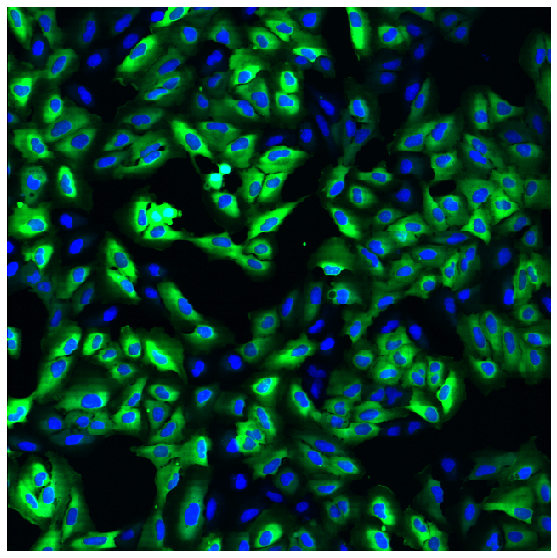

In [24]:
fig, ax = plt.subplots(figsize=(10,10))
microplot.microshow([image1, image2], rescale_type='limits', limits=[0,100],  cmaps=['pure_green','pure_blue'], ax=ax);

### Thresholding

As a simplified pipeline, we segment the nuclei just by thresholding. For the flexibility and reproudicility of the analysis it's best not to set arbitrarily values such as thresholds empirically. Ideally one should use an automated method e.g. Otsu:

In [25]:
threshold = skimage.filters.threshold_otsu(image2)
mask = image2 > threshold

Now that we have a mask we also need to detect connected components (particles) i.e. groups of pixels belonging to separate nuclei:

In [26]:
mask_lab = skimage.measure.label(mask)

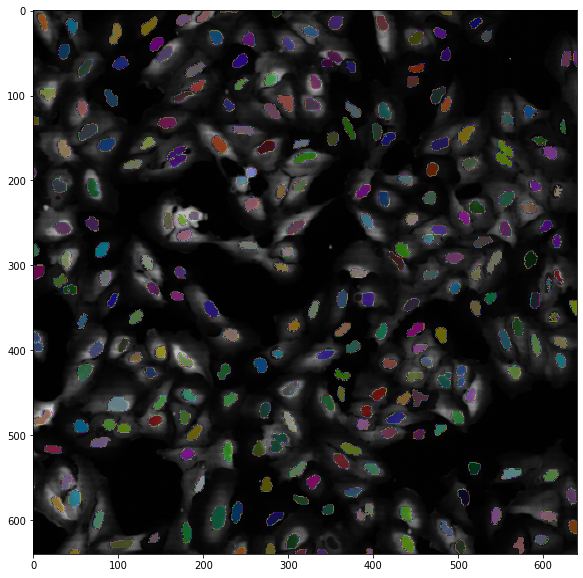

In [31]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(image1, cmap = 'gray')
ax.imshow(mask_lab.astype(np.uint8), cmap=microplot.random_cmap());

### Measure regions

Now that we have identified all the nuclei, we can measure their properties, including the intensity in the other channel:

In [32]:
regions = skimage.measure.regionprops_table(mask_lab, intensity_image=image1,
                                           properties=('label','area','mean_intensity'))

We can turn this output into an easy to handle Pandas Dataframe:

In [33]:
import pandas as pd
regions = pd.DataFrame(regions)
regions.head()

,label,area,mean_intensity
0,1,180,42.644444
1,2,64,18.656250
2,3,87,3.517241
3,4,83,15.614458
4,5,160,51.668750


In [34]:
regions['mean_intensity'].mean()

26.829120444044293

### Clean-up

Before we proceed, we look at some of the outputs. For example we check the distribution of sizes:

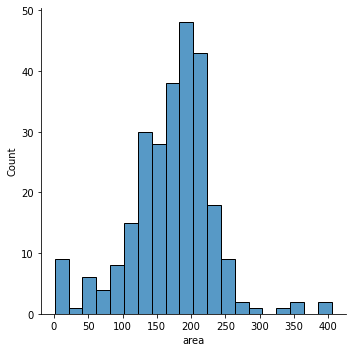

In [35]:
import seaborn as sns
import pandas as pd

sns.displot(data=regions, x='area');

We see that we have a small proportion of debris creating a "peak" at small areas. It is reasonable to set a size cutoff (as long as it's explicitly stated of course!). We can do this by indexing:

In [36]:
area_threshold = 50
selected_regions = regions[regions['area'] > area_threshold]
selected_regions.mean()

label             132.488189
area              178.366142
mean_intensity     26.706697
dtype: float64

### Complete pipeline

After developing the pipeline step by step, we can now summarize it. It's good policy to for example create a function wrapping all of our commands. This makes code re-usable and more flexible:

In [37]:
def my_segmentation(image1, image2, area_threshold):
    
    threshold = skimage.filters.threshold_otsu(image2)
    mask = image2 > threshold
    mask_lab = skimage.measure.label(mask)

    regions = skimage.measure.regionprops_table(mask_lab, intensity_image=image1,
                                           properties=('label','area','mean_intensity'))
    regions = pd.DataFrame(regions)
    selected_regions = regions[regions['area'] > area_threshold]
    return selected_regions

In [38]:
output = my_segmentation(image1,image2, area_threshold=50)
output.mean()

label             132.488189
area              178.366142
mean_intensity     26.706697
dtype: float64

## Combine with metadata

Now we have a way to extract inforamtion from eaach image and from the file name we can also know from which well the data came. We therefore want to combine already available information (drug treatment) with our extracted information.

### Import metadata

Let's start by importing the metadata. They are stored in a text file hosted at the same place as the images. We can simply import it with Pandas:

In [39]:
import pandas as pd
import numpy as np

In [40]:
drugs = pd.read_csv('https://data.broadinstitute.org/bbbc/BBBC013/BBBC013_v1_platemap_all.txt')
len(drugs)

96

We have a list of 96 conditions. To match each confition to a well, we reshape this list into a standard 8x12 grid of data:

In [41]:
drug_amounts = pd.DataFrame(np.reshape(drugs.values, (8,12)))
drug_amounts

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,0.0,0.98,1.95,3.91,7.81,15.63,31.25,62.5,125.0,250.0,150.0
1,0.0,0.0,0.98,1.95,3.91,7.81,15.63,31.25,62.5,125.0,250.0,150.0
2,0.0,0.0,0.98,1.95,3.91,7.81,15.63,31.25,62.5,125.0,250.0,150.0
3,0.0,0.0,0.98,1.95,3.91,7.81,15.63,31.25,62.5,125.0,250.0,150.0
4,80.0,0.0,0.31,0.63,1.25,2.50,5.00,10.00,20.0,40.0,80.0,0.0
5,80.0,0.0,0.31,0.63,1.25,2.50,5.00,10.00,20.0,40.0,80.0,0.0
6,80.0,0.0,0.31,0.63,1.25,2.50,5.00,10.00,20.0,40.0,80.0,0.0
7,80.0,0.0,0.31,0.63,1.25,2.50,5.00,10.00,20.0,40.0,80.0,0.0


To match the positions in the well with the names extracted from the image names, we also rename the rows and columns of the table: 

In [42]:
import string
alphabetical = [string.ascii_uppercase[i] for i in range(12)]
alphabetical

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']

In [43]:
drug_amounts.rename({i: i+1 for i in range(12)}, axis='columns', inplace=True)
drug_amounts.rename({i: alphabetical[i] for i in range(12)}, axis='rows', inplace=True)
drug_amounts

,1,2,3,4,5,6,7,8,9,10,11,12
A,0.0,0.0,0.98,1.95,3.91,7.81,15.63,31.25,62.5,125.0,250.0,150.0
B,0.0,0.0,0.98,1.95,3.91,7.81,15.63,31.25,62.5,125.0,250.0,150.0
C,0.0,0.0,0.98,1.95,3.91,7.81,15.63,31.25,62.5,125.0,250.0,150.0
D,0.0,0.0,0.98,1.95,3.91,7.81,15.63,31.25,62.5,125.0,250.0,150.0
E,80.0,0.0,0.31,0.63,1.25,2.50,5.00,10.00,20.0,40.0,80.0,0.0
F,80.0,0.0,0.31,0.63,1.25,2.50,5.00,10.00,20.0,40.0,80.0,0.0
G,80.0,0.0,0.31,0.63,1.25,2.50,5.00,10.00,20.0,40.0,80.0,0.0
H,80.0,0.0,0.31,0.63,1.25,2.50,5.00,10.00,20.0,40.0,80.0,0.0


Additionally, we create a second table which contains information on the drug type. We have to create that table manually:

In [44]:
drug_type = drug_amounts.copy()
drug_type[:] = 'Control'

drug_type.iloc[0:4,2:-1] = 'Wortmannin' 
drug_type.iloc[4:8,2:-1] = 'LY294002'
drug_type.iloc[0:4,0] = 'Negative Control'
drug_type.iloc[4:8,-1] = 'Negative Control'
drug_type.iloc[4:8,0] = 'Positive Control'
drug_type.iloc[0:4,-1] = 'Positive Control'
drug_type.iloc[:,1] = 'Empty'

drug_type

,1,2,3,4,5,6,7,8,9,10,11,12
A,Negative Control,Empty,Wortmannin,Wortmannin,Wortmannin,Wortmannin,Wortmannin,Wortmannin,Wortmannin,Wortmannin,Wortmannin,Positive Control
B,Negative Control,Empty,Wortmannin,Wortmannin,Wortmannin,Wortmannin,Wortmannin,Wortmannin,Wortmannin,Wortmannin,Wortmannin,Positive Control
C,Negative Control,Empty,Wortmannin,Wortmannin,Wortmannin,Wortmannin,Wortmannin,Wortmannin,Wortmannin,Wortmannin,Wortmannin,Positive Control
D,Negative Control,Empty,Wortmannin,Wortmannin,Wortmannin,Wortmannin,Wortmannin,Wortmannin,Wortmannin,Wortmannin,Wortmannin,Positive Control
E,Positive Control,Empty,LY294002,LY294002,LY294002,LY294002,LY294002,LY294002,LY294002,LY294002,LY294002,Negative Control
F,Positive Control,Empty,LY294002,LY294002,LY294002,LY294002,LY294002,LY294002,LY294002,LY294002,LY294002,Negative Control
G,Positive Control,Empty,LY294002,LY294002,LY294002,LY294002,LY294002,LY294002,LY294002,LY294002,LY294002,Negative Control
H,Positive Control,Empty,LY294002,LY294002,LY294002,LY294002,LY294002,LY294002,LY294002,LY294002,LY294002,Negative Control


Finally we turn the tables into long format, with each row of the table containing row, column, drug type and amount. For that we pivot the tables and merge them:

In [45]:
drug_amounts.reset_index().melt(id_vars='index').head(5)

,index,variable,value
0,A,1,0.0
1,B,1,0.0
2,C,1,0.0
3,D,1,0.0
4,E,1,80.0


In [46]:
drug_info = pd.merge(drug_amounts.reset_index().melt(id_vars='index'),
         drug_type.reset_index().melt(id_vars='index'), on=['index', 'variable'])
drug_info.rename({'index': 'row', 'variable': 'column', 'value_x': 'amount', 'value_y': 'drug type'},
                 axis='columns', inplace=True)
drug_info = drug_info.set_index(['row', 'column'])
drug_info.head(5)

,,amount,drug type
row,column,,
A,1,0.0,Negative Control
B,1,0.0,Negative Control
C,1,0.0,Negative Control
D,1,0.0,Negative Control
E,1,80.0,Positive Control


### Complete with new information

We are now adding columns to that table which will contain all our results:

In [47]:
drug_info['area'] = np.nan
drug_info['intensity'] = np.nan
drug_info['number nuclei'] = np.nan
drug_info.head(5)

,,amount,drug type,area,intensity,number nuclei
row,column,,,,,
A,1,0.0,Negative Control,NaN,NaN,NaN
B,1,0.0,Negative Control,NaN,NaN,NaN
C,1,0.0,Negative Control,NaN,NaN,NaN
D,1,0.0,Negative Control,NaN,NaN,NaN
E,1,80.0,Positive Control,NaN,NaN,NaN


Finally, using the well location information extracted from the file name, we can complete the table with the *measured* data:

In [48]:
position

[('A', '09')]

In [52]:
drug_info.loc[(position[0][0], int(position[0][1])),'area'] = regions['area'].mean()

Now we repeat the operation for each file in our folder. In addition to the mean values stored in ```drug_info``` we also keep the full intensity distributions as a list of DataFrames that we can concatenate at the end:

In [53]:
area_threshold = 50
full_distributions= []
for f1, f2 in zip(file_list1, file_list2):
    
    image1 = skimage.io.imread(f1)
    image2 = skimage.io.imread(f2)

    regions = my_segmentation(image1,image2, area_threshold=area_threshold)
    
    position = re.findall('.*\-.*\-(.*)\-(.*)\.BMP',f1.name)
    
    drug_info.loc[(position[0][0], int(position[0][1])),'area'] = regions['area'].mean()
    drug_info.loc[(position[0][0], int(position[0][1])),'intensity'] = regions['mean_intensity'].mean()
    drug_info.loc[(position[0][0], int(position[0][1])),'number nuclei'] = len(regions)

    # keep complete distributions
    distr = regions.drop('label',axis='columns')
    distr['amount'] = drug_info.loc[(position[0][0], int(position[0][1]))]['amount']
    distr['drug type'] = drug_info.loc[(position[0][0], int(position[0][1]))]['drug type']
    distr['well row'] = position[0][0]
    distr['well column'] = int(position[0][1])
    full_distributions.append(distr)

full_distributions = pd.concat(full_distributions)
full_distributions.rename({'mean_intensity': 'intensity'}, axis='columns', inplace=True)

In [54]:
drug_info

,,amount,drug type,area,intensity,number nuclei
row,column,,,,,
A,1,0.0,Negative Control,182.006780,22.666447,295.0
B,1,0.0,Negative Control,178.280255,26.306847,157.0
C,1,0.0,Negative Control,182.649007,33.285372,151.0
D,1,0.0,Negative Control,190.920732,35.943763,164.0
E,1,80.0,Positive Control,187.769231,49.245178,182.0
...,...,...,...,...,...,...
D,12,150.0,Positive Control,179.518987,86.719140,158.0
E,12,0.0,Negative Control,165.988571,25.168306,175.0
F,12,0.0,Negative Control,173.591398,31.286983,186.0


In [55]:
#drug_info = pd.merge(drug_amounts.stack().reset_index(), drug_type.stack().reset_index(), on=('level_0', 'level_1'))
#drug_info.rename({'level_0': 'well row', 'level_1': 'well column', '0_x': 'amount', '0_y': 'drug type'}, axis=1, inplace=True)
#drug_info = drug_info.set_index(['well row', 'well column'])

## Plotting

We show the statistical analyis in detail in the R notebook. We just quickly show here a series of tools that can be useful if you want to perform your entire analysis in the Python world.

There are multiple plotting librarie with different "philosphies". One of the most popoular and efficient ones is seaborn. It is designed to work with DataFrames and handles a lot of the boiler-plate code (e.g. axis naming) automatically:

In [56]:
import seaborn as sns

In [57]:
clean_drug = drug_info[drug_info['drug type'].isin(['LY294002','Wortmannin'])]

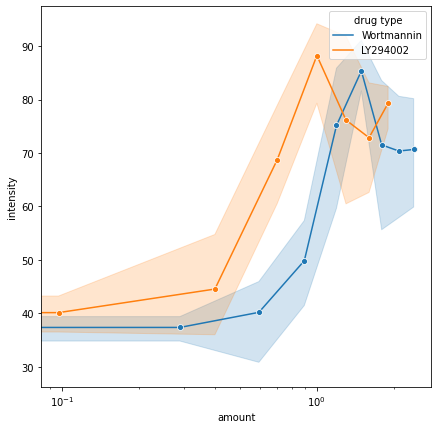

In [58]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log")
sns.lineplot(data=clean_drug, x='amount', y='intensity', hue='drug type', ax=ax, marker="o");

We can also perform function fits to the data with packages like scikit-learn or scipy. Here we try a linear fit to the above curve:

In [59]:
from sklearn import linear_model

In [61]:
X = clean_drug.sort_values(by='amount')['amount'].values
X = X[:, np.newaxis]
y = clean_drug.sort_values(by='amount')['intensity'].values

ols = linear_model.LinearRegression()
ols.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

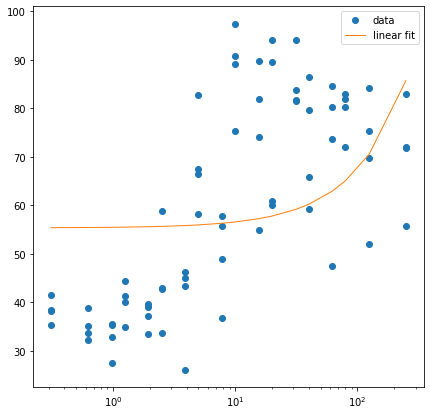

In [62]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(X,y,'o', label='data')
ax.plot(X, ols.coef_ * X + ols.intercept_, linewidth=1, label='linear fit')
ax.set(xscale="log");
ax.legend()


We see that the fit is very poor as we rather have a sigmoind response curve to the drug. Let's try to do such a fit with scipy where we can explicitly creata a fit function:

In [64]:
from scipy.optimize import curve_fit

def sigmoid (x, A, h, slope, C):
    return 1 / (1 + np.exp ((x - h) / slope)) *  A + C

p, _ = curve_fit(sigmoid, np.ravel(X), y)
x = np.ravel(X)

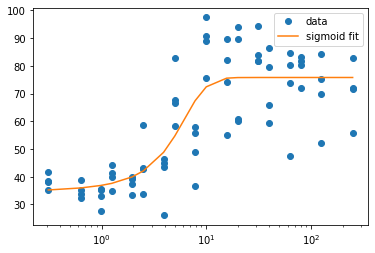

In [66]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.plot(x, y, 'o', label='data')
ax.plot(x, sigmoid(x, *p), label='sigmoid fit')
ax.legend();

Finally we can also look at various histograms. For example we can compare the histograms of teh average nucleus size as a function of drug treatment or the histoggram of the single nuclei size: 

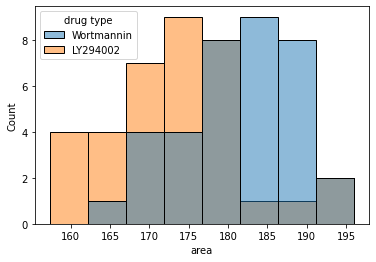

In [67]:
sns.histplot(data=clean_drug.reset_index(), x='area', hue='drug type');

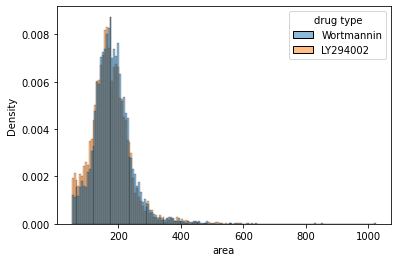

In [68]:
clean_full = full_distributions.reset_index()
clean_full_drug = clean_full[clean_full['drug type'].isin(['LY294002','Wortmannin'])]
sns.histplot(data=clean_full_drug, x='area', hue='drug type', stat='density', common_norm=False);

This is a good example where looking at the full distribution (minor difference at small sizes) yields a rather different results than looking at the average.

Histograms are in general useful to understand what happens in an averaged value. For example we can ask whether the increase in intensity as a function of drug concentration is a *smooth* transition or the results of a *bi-modal* shift.


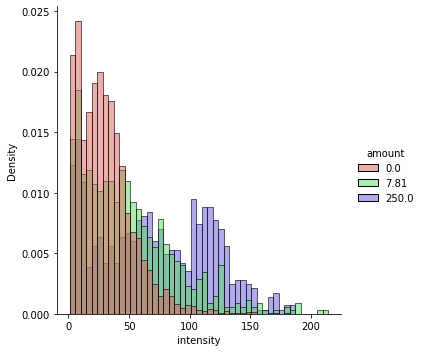

In [69]:
sns.displot(data=clean_full[(clean_full.amount==0) | (clean_full.amount==7.81) | (clean_full.amount==250)], x='intensity', hue='amount', stat='density', common_norm=False,
            palette=sns.color_palette("hls", 3));

## Export the data

Finally we can export our data as tables that we can then re-use in other software e.g. our statistical analysis R notebook.

In [181]:
drug_info.reset_index().to_csv('BBBC013_analyzed.csv', index=False)

In [182]:
full_distributions.to_csv('BBBC013_analyzed_full.csv', index=False)